In [1]:
import random
from fractions import Fraction
import re
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
def generate_fraction():
    numerator = random.randint(1, 9)
    denominator = random.randint(numerator + 1, 12)
    return Fraction(numerator, denominator)

def random_sign():
    return random.choice([1, 1, 1, -1])

def format_fraction(frac):
    return f"{frac.numerator}/{frac.denominator}"

def format_operand(frac):
    sign = "-" if frac < 0 else ""
    frac = abs(frac)
    return f"{sign}{frac.numerator}/{frac.denominator}"

def generate_fraction_addition_dataset(n=100):
    dataset = []
    for _ in range(n):
        operands = [random_sign() * generate_fraction() for _ in range(2)]
        expr_str = " + ".join([format_operand(op) for op in operands])
        result = sum(operands)
        dataset.append((expr_str, format_fraction(result)))
    return dataset

In [3]:
dataset = generate_fraction_addition_dataset(10)
for q, a in dataset:
    print(f"{q} = {a}")

2/3 + -1/2 = 1/6
4/9 + 5/12 = 31/36
-7/11 + 7/12 = -7/132
3/11 + -5/11 = -2/11
-7/12 + 3/4 = 1/6
1/2 + 4/9 = 17/18
1/2 + 6/7 = 19/14
3/5 + 5/12 = 61/60
-3/4 + 8/9 = 5/36
1/11 + 3/4 = 37/44


In [4]:
import requests

def steer_fraction_addition(prompt, strength):
    url = "https://www.neuronpedia.org/api/steer"
    headers = {"Content-Type": "application/json"}

    payload = {
        "prompt": prompt,
        "modelId": "deepseek-r1-distill-llama-8b",
        "features": [
            {
                "modelId": "deepseek-r1-distill-llama-8b",
                "layer": "15-llamascope-slimpj-res-32k",
                "index": 30939,
                "strength": strength
            }
        ],
        "temperature": 0.5,
        "n_tokens": 128, #максимум не дает сделат больше из-за чего все размышления не помещаються в контекст
        "strength_multiplier": 1,
        "seed": 16,
        "freq_penalty":1
    }

    response = requests.post(url, headers=headers, json=payload)
    return response.json()


In [5]:
strengths = [-10, -7, -3, -5, -2, -1, 1, 2, 5, 10, 50]
results = []
answers = {}
for sm in tqdm(strengths):
    correct = 0
    answers[sm] = []
    for q, expected in dataset:
        response = steer_fraction_addition(
            prompt=f"what is {q}? make short answer .",
            strength=sm
        )
        answers[sm].append(response)


100%|██████████| 11/11 [27:22<00:00, 149.36s/it]


In [6]:
def extract_last_fraction(text):
    fractions = re.findall(r"(?:\\frac\{(\d+)\}\{(\d+)\}|(\-?\d+/\d+))", text)
    extracted = []
    for num1, den1, simple_frac in fractions:
        if num1 and den1:
            extracted.append(f"{num1}/{den1}")
        elif simple_frac:
            extracted.append(simple_frac)
    return extracted[-1] if extracted else None

def is_answer_correct(model_output, expected_answer):
    last_frac = extract_last_fraction(model_output)
    if not last_frac:
        return False

    try:
        model_frac = Fraction(last_frac)
        expected_frac = Fraction(expected_answer)
        return model_frac == expected_frac
    except:
        return False

In [7]:
n = -5
accuracy_start = 0
for ind in range(len(answers[n])):
  accuracy_start = accuracy_start + is_answer_correct(answers[n][ind]['DEFAULT'], str(dataset[ind][1]))
accuracy_start

0

In [19]:
# Пример выводы
for ind in range(len(answers[-5])):
  print("Ответ модели:", answers[-5][ind]['DEFAULT'])
  print("\n\n\n")
  print("Ожидаемый ответ: ", dataset[ind][1])
  print('_'*20)

Ответ модели: what is 2/3 + -1/2? make short answer . please.

First, I need to add the two fractions: 2/3 and -1/2. To do this, I should find a common denominator for the fractions. The denominators are 3 and 2, so the least common denominator (LCD) is 6.

Next, I'll convert each fraction to have the LCD as its denominator. For 2/3, multiplying both the numerator and denominator by 2 gives me 4/6. For -1/2, multiplying both the numerator and denominator by 3 results in -3/6.

Now that both fractions have the same denominator, I can




Ожидаемый ответ:  1/6
____________________
Ответ модели: what is 4/9 + 5/12? make short answer . Okay, so I need to figure out what 4/9 plus 5/12 is. Hmm, adding fractions can be tricky, but I remember that you need a common denominator first. Let me think about how to find the least common denominator for 9 and 12. The denominators are 9 and 12, right? So, I guess the least common multiple of 9 and 12 would be... let me see. 

Well, breaking them down 

In [8]:
res_acc = {}
for n in strengths:
  res_acc[n] = 0
  for ind in range(len(answers[n])):
    res_acc[n] = res_acc[n] + is_answer_correct(answers[n][ind]['STEERED'], str(dataset[ind][1]))

In [13]:
res_acc = {k: res_acc[k] for k in sorted(res_acc)}

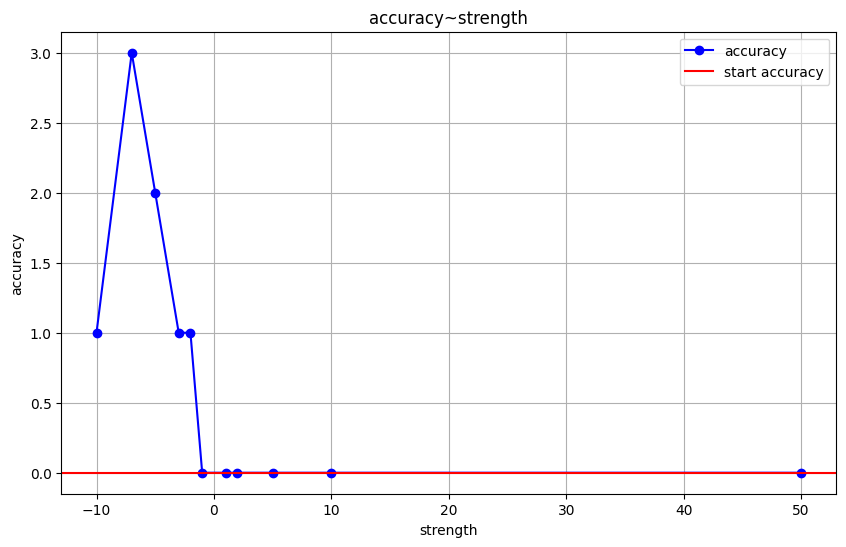

In [14]:
x = list(res_acc.keys())
y = list(res_acc.values())

plt.figure(figsize=(10, 6))

plt.plot(x, y, 'bo-', label='accuracy')
plt.axhline(y=accuracy_start, color='r', linestyle='-', label='start accuracy')
plt.xlabel('strength')
plt.ylabel('accuracy')
plt.title('accuracy~strength')
plt.grid(True)
plt.legend()


plt.show()